In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from __future__ import print_function
import argparse
import os
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import cv2
import sys
from PIL import Image

In [2]:
class Critic(nn.Module):
  def __init__(self, channels_img, features_d):
    super(Critic, self).__init__()
    self.critic = nn.Sequential(
        #input: N x channels_img x 64 x 64
        nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),

        #self._block(self, in_channels, out_channels, kernel_size, stride, padding)
        self._block(features_d, features_d * 2, 4, 2, 1),
        self._block(features_d * 2, features_d * 4, 4, 2, 1),
        self._block(features_d * 4, features_d * 8, 4, 2, 1),

        #After all _block image size is 4x4 (convolution below make it into a 1x1)
        nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0)
    )


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
          in_channels,
          out_channels,
          kernel_size,
          stride,
          padding,
          bias=False
        ),
        nn.InstanceNorm2d(out_channels, affine=True),
        nn.LeakyReLU(0.2)   
      )
    
  def forward(self, x):
    return self.critic(x)

In [3]:
class Generator(nn.Module):
  def __init__(self,  z_dim, channels_img, features_g):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        #input: N x z_dim x 1 X 1
        #self._block(self, in_channels, out_channels, kernel_size, stride, padding)
        self._block(z_dim, features_g * 16, 4, 1, 0),
        self._block(features_g * 16, features_g * 8, 4, 2, 1),
        self._block(features_g * 8, features_g * 4, 4, 2, 1),
        self._block(features_g * 4, features_g * 2, 4, 2, 1),

        nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),

        #Output: img N x channels_img x 64 x 64

        nn.Tanh() #[-1, 1]
    )


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
      nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False
      ),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()   
  )
    
  def forward(self, x):
    return self.gen(x)

In [4]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
def test():
  N, in_channels, H, W = 8, 3, 64, 64
  z_dim = 100
  x = torch.randn((N, in_channels, H, W))

  critic = Critic(in_channels, 8)
  initialize_weights(critic)
  assert critic(x).shape == (N, 1, 1, 1), "Critic test failed"
  print("Critic test successfull")

  gen = Generator(z_dim, in_channels, 8)
  initialize_weights(gen)
  z = torch.randn((N, z_dim, 1, 1))
  assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
  print("Generator test successfull")
  print("Test succesfull")

In [6]:
def gradient_penalty(critic, real, fake, device):
  BATCH_SIZE, C, H, W = real.shape
  epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
  interpolated_images = real * epsilon + fake * (1 - epsilon)

  #Calculate Critic scores
  mixed_scores = critic(interpolated_images)

  gradient = torch.autograd.grad(
      inputs=interpolated_images,
      outputs=mixed_scores,
      grad_outputs=torch.ones_like(mixed_scores),
      create_graph=True,
      retain_graph=True
  )[0]
  
  gradient = gradient.view(gradient.shape[0], -1)
  gradient_norm = gradient.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
  
  return gradient_penalty

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
LEARNING_RATE_GEN = 1e-4  # could also use two lrs, one for gen and one for critic
LEARNING_RATE_CRITIC = 1e-4 
BATCH_SIZE = 1
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

In [9]:
transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)])
    ]
)

In [10]:
dataroot = "C:/Users/zlata/base_landscape"
dataset = datasets.ImageFolder(root=dataroot,transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
torch.cuda.empty_cache() 
import gc
gc.collect()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [12]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN)
critic = Critic(CHANNELS_IMG, FEATURES_CRITIC)
gen.to(device)
critic.to(device)

Critic(
  (critic): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [13]:
initialize_weights(gen)
initialize_weights(critic)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE_GEN, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE_CRITIC, betas=(0.0, 0.9))
fixed_noise = torch.randn(32,Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0
gen.train()
critic.train()

Critic(
  (critic): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

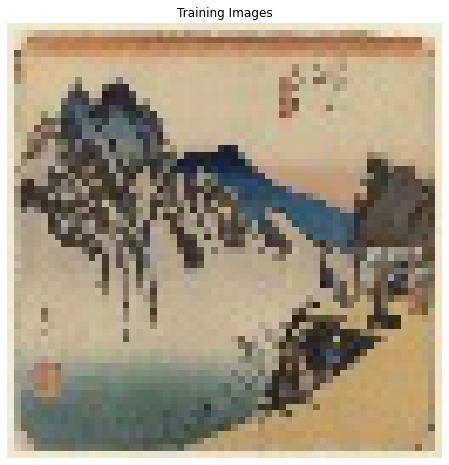

In [15]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [16]:
z = torch.randn(64, Z_DIM, 1, 1).to(device)

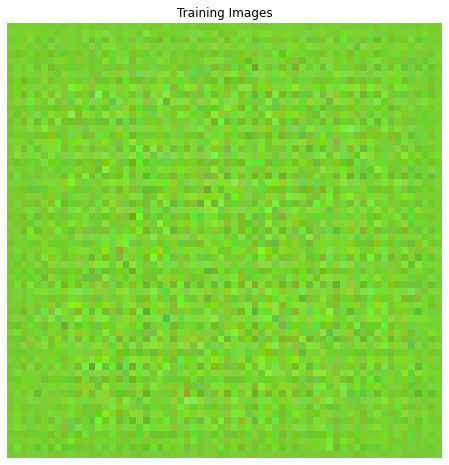

In [17]:
fake_batch = gen(z)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(fake_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [22]:
img_list = []
img_list_fixed = []
G_losses = [] #loss funkcija za G
D_losses = [] #loss funkcija za D
D_real = [] #broj tacno pogodjenih realnih slika
D_fake = [] #broj tacno pogodjenih fejk slika
iters = 0
noise =  torch.randn(64, Z_DIM, 1, 1).to(device)

In [ ]:
print("Starting Training Loop...")
for epoch in range(NUM_EPOCHS):

  z_test = torch.randn(64, Z_DIM, 1, 1).to(device)
  fake_batch_test = gen(z_test)
  plt.figure(figsize=(8,8))
  plt.axis("off")
  plt.title("Training Images")
  plt.imshow(np.transpose(vutils.make_grid(fake_batch_test[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

  for batch_index, (real, _) in enumerate(dataloader):
      real = real.to(device)
      z = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
      fake = gen(z)
      fake_fixed = gen(noise)
      for _ in range (CRITIC_ITERATIONS):
          z = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
          fake = gen(z)

          critic_real = critic(real).reshape(-1)
          critic_fake = critic(fake.detach()).reshape(-1)

          gp = gradient_penalty(critic, real, fake, device)
          
          loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
          critic.zero_grad()
          loss_critic.backward(retain_graph=True)
          opt_critic.step()

      output = critic(fake).reshape(-1)
      loss_gen = -torch.mean(output)

      gen.zero_grad()
      loss_gen.backward()
      opt_gen.step()
    
      if batch_index % 100 == 0:
        print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_index}/{len(dataloader)} \ Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}")
      
      # Save Losses for plotting later
      G_losses.append(loss_gen.item())
      D_losses.append(loss_critic.item())
    
      D_real.append((torch.mean(critic_real)).item())
      D_fake.append((torch.mean(critic_fake)).item())
        # Check how the generator is doing by saving G's output on fixed_noise
        
      if (iters % 500 == 0) or ((epoch == NUM_EPOCHS-1) and (i == len(dataloader)-1)):
        with torch.no_grad():
            fake = fake.detach().cpu()
            fake_fixed = fake.detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            img_list_fixed.append(vutils.make_grid(fake, padding=2, normalize = True))
      iters += 1

Starting Training Loop...
Epoch [0/5] Batch 0/30012 \ Loss D: 417.5515, loss G: 3.0518
Epoch [0/5] Batch 100/30012 \ Loss D: -45.3320, loss G: 53.8416
Epoch [0/5] Batch 200/30012 \ Loss D: -16.3718, loss G: 65.2323
Epoch [0/5] Batch 300/30012 \ Loss D: -76.0708, loss G: 65.0603
Epoch [0/5] Batch 400/30012 \ Loss D: -26.1830, loss G: 70.6627
Epoch [0/5] Batch 500/30012 \ Loss D: -75.1418, loss G: 89.0461
Epoch [0/5] Batch 600/30012 \ Loss D: -40.7908, loss G: 81.6196
Epoch [0/5] Batch 700/30012 \ Loss D: -40.2163, loss G: 97.3286
Epoch [0/5] Batch 800/30012 \ Loss D: -32.9038, loss G: 65.8285
Epoch [0/5] Batch 900/30012 \ Loss D: -97.5285, loss G: 89.1699
Epoch [0/5] Batch 1000/30012 \ Loss D: -27.8213, loss G: 45.9105
Epoch [0/5] Batch 1100/30012 \ Loss D: -88.0678, loss G: 126.8617
Epoch [0/5] Batch 1200/30012 \ Loss D: -114.2167, loss G: 57.7347
Epoch [0/5] Batch 1300/30012 \ Loss D: -187.9064, loss G: 123.7651
Epoch [0/5] Batch 1400/30012 \ Loss D: -144.0453, loss G: 83.8300
Epoch [

In [ ]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Discriminator's guesses on real and fake images")
plt.plot(D_real,label="Real")
plt.plot(D_fake,label="Fake")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#generating images for further evaluation
image_list = []
iters = 0
for batch_index, (real, _) in enumerate(dataloader):
    while (iters < 200):
      real = real.to(device)
      for _ in range (CRITIC_ITERATIONS):
          z = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
          fake = gen(z)
    
      if batch_index % 100 == 0:
        print(f"Batch {batch_index}/{len(dataloader)}")
        
      if (iters < 500 == 0) or ((epoch == NUM_EPOCHS-1) and (i == len(dataloader)-1)):
        with torch.no_grad():
            fake = fake.detach().cpu()
            image_list.append(vutils.make_grid(fake, padding=2, normalize=True))
      iters += 1

In [ ]:
#downloading the generated images
for i in range(1,200):
    image = np.transpose(img_list[-1*i],(1,2,0))
    image = image*255
    image  = image.cpu().numpy() # make sure tensor is on cpu
    image2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite('C:/Users/zlata/pictures_for_evaluation/WGAN/'+str(i)+'.jpg', image2)

In [14]:
import gc

gc.collect()

torch.cuda.empty_cache()

